<a href="https://colab.research.google.com/github/melataguia/regretion_cluster../blob/main/gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation de la bibliothèque xgboost

In [1]:
install.packages("xgboost")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Charger les bibliothèques nécessaires

In [43]:
library(xgboost)
library(ggplot2)



```
# Ce texte est au format code
```

# Charger les données

In [13]:
movies <- read.csv('../movies.csv')
ratings <- read.csv('../ratings.csv')
#tags <- read.csv('./tags.csv')

# Vérifier les données manquantes

In [18]:
missing_ratings <- colSums(is.na(ratings))
cat("Missing values in 'ratings':\n")
print(missing_ratings)

Missing values in 'ratings':
   userId   movieId    rating timestamp 
        0         0         0         6 


In [19]:
missing_movies <- colSums(is.na(movies))
cat("\nMissing values in 'movies':\n")
print(missing_movies)


Missing values in 'movies':
movieId   title  genres 
      0       0       0 


##Supprimer les lignes avec des valeurs manquantes dans le dataframe 'ratings'


In [20]:
ratings <- ratings[complete.cases(ratings), ]

##Supprimer les lignes avec des valeurs manquantes dans le dataframe 'movies'

In [21]:
movies <- na.omit(movies)

###Afficher le nombre de lignes après suppression des valeurs manquantes pour chaque dataframe


In [22]:
cat("Nombre de lignes après suppression des valeurs manquantes dans 'ratings':", nrow(ratings), "\n")
cat("Nombre de lignes après suppression des valeurs manquantes dans 'movies':", nrow(movies), "\n")

Nombre de lignes après suppression des valeurs manquantes dans 'ratings': 274089 
Nombre de lignes après suppression des valeurs manquantes dans 'movies': 9742 


# Fusion des données

In [23]:
data <- merge(ratings, movies, by = "movieId")

###Afficher les premières lignes de la dataframe 'data'

In [25]:
print(head(data))

  movieId userId rating  timestamp            title
1       1      1    4.0  964982703 Toy Story (1995)
2       1    232    3.5 1076955621 Toy Story (1995)
3       1    474    4.0  978575760 Toy Story (1995)
4       1    484    4.5 1342295949 Toy Story (1995)
5       1    304    5.0  881428344 Toy Story (1995)
6       1    471    5.0 1496671820 Toy Story (1995)
                                       genres
1 Adventure|Animation|Children|Comedy|Fantasy
2 Adventure|Animation|Children|Comedy|Fantasy
3 Adventure|Animation|Children|Comedy|Fantasy
4 Adventure|Animation|Children|Comedy|Fantasy
5 Adventure|Animation|Children|Comedy|Fantasy
6 Adventure|Animation|Children|Comedy|Fantasy


# Diviser les données en ensembles d'apprentissage et de test

In [26]:
set.seed(123)  # Pour la reproductibilité
train_indices <- sample(1:nrow(ratings), 0.8 * nrow(ratings))
train_data <- ratings[train_indices, ]
test_data <- ratings[-train_indices, ]

#Étape 1 : Prédire les recommandations en fonction de la moyenne des observations

In [34]:
# Définition des hyperparamètres
num_iterations <- 100
learning_rate <- 0.01

# Initialisation des prédictions sur l'ensemble d'entraînement et de test
train_data$prediction <- 0
test_data$prediction <- 0

In [35]:
mean_rating <- mean(train_data$rating)

# Étape 2 à 5 : Construction progressive du modèle avec XGBoost

In [ ]:


for (i in 1:num_iterations) {
  # Étape 2 : Calcul des résidus
  train_data$residual <- train_data$rating - train_data$prediction

  # Étape 3 : Construction du modèle XGBoost pour prédire les résidus
  xgb_model <- xgboost(data = as.matrix(train_data[, c("userId", "movieId")]),
                       label = train_data$residual,
                       nrounds = 50,
                       eta = learning_rate)

  # Étape 4 : Mise à jour des prédictions sur l'ensemble d'entraînement
  train_data$prediction <- train_data$prediction + predict(xgb_model, as.matrix(train_data[, c("userId", "movieId")]))

  # Étape 5 : Mise à jour des prédictions sur l'ensemble de test
  test_data$prediction <- test_data$prediction + predict(xgb_model, as.matrix(test_data[, c("userId", "movieId")]))
}

# Moyenne des prédictions sur l'ensemble d'entraînement et de test
train_data$prediction <- mean_rating + train_data$prediction / num_iterations
test_data$prediction <- mean_rating + test_data$prediction / num_iterations


# Évaluation des performances du modèle en  utilisant l'erreur quadratique moyenne (RMSE)

In [38]:
rmse <- sqrt(mean((test_data$rating - test_data$prediction)^2))
cat("RMSE sur l'ensemble de test :", rmse, "\n")


RMSE sur l'ensemble de test : 1.041599 


In [40]:
# Calcul de la MAE
mae <- mean(abs(test_data$rating - test_data$prediction))

# Calcul de la Median Absolute Error
median_absolute_error <- median(abs(test_data$rating - test_data$prediction))

# Affichage des résultats
cat("MAE sur l'ensemble de test :", mae, "\n")
cat("Median Absolute Error sur l'ensemble de test :", median_absolute_error, "\n")


MAE sur l'ensemble de test : 0.8232204 
Median Absolute Error sur l'ensemble de test : 0.5103939 


## Calcul des erreurs absolues


In [44]:
test_data$error <- abs(test_data$rating - test_data$prediction)



# Construction de l'histogramme


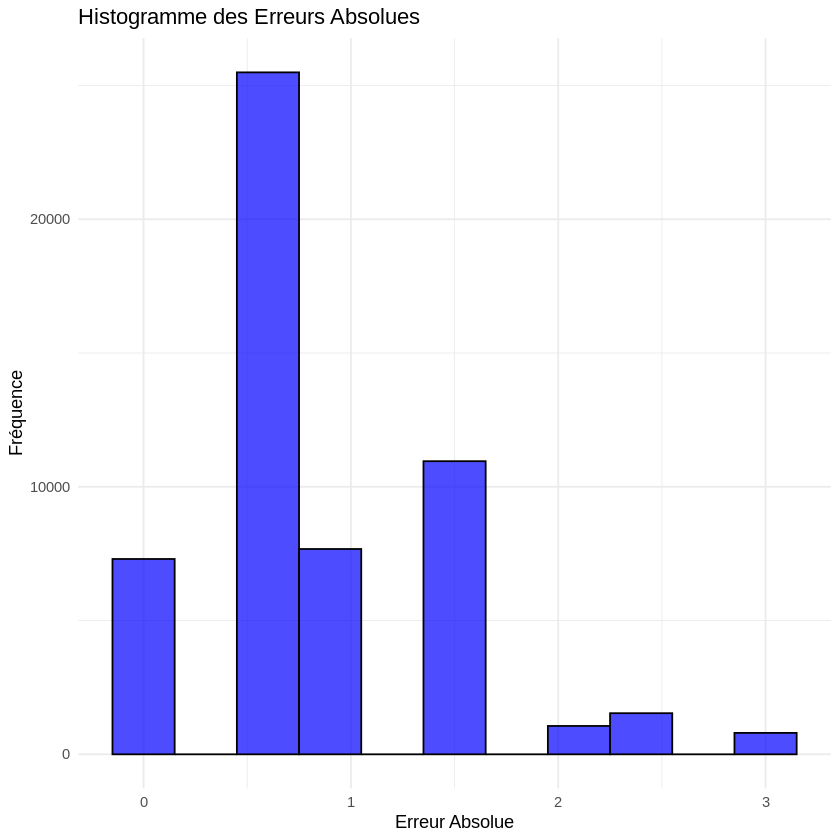

In [46]:
ggplot(test_data, aes(x = error)) +
  geom_histogram(binwidth = 0.3, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Histogramme des Erreurs Absolues",
       x = "Erreur Absolue",
       y = "Fréquence") +
  theme_minimal()